# Preparação dos dados

In [ ]:
import pandas as pd

# Lê o arquivo .csv
df = pd.read_csv('ge_news.csv')

# Exibe as primeiras linhas
df.head()

In [ ]:
# Removendo simultaneamente as colunas de índice 0, 1, 4 (date, time and link)
column_indices = [0, 1, 4]
df.drop([df.columns[i] for i in column_indices], axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
# Fundindo colunas 'title' e 'text' para a coluna 'title_and_text'
df['data'] = df['title'] + ' ' + df['text']

In [ ]:
df.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Treinando o codificador de rótulos, transformando o nome do clube em um identificador numérico
df['label'] = le.fit_transform(df['club'])

In [ ]:
df['club'].unique(), df['label'].unique()

In [ ]:
# Removendo as colunas originais, não precisamos mais delas
column_indices = [0, 1, 2]
df.drop([df.columns[i] for i in column_indices], axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Conta quantos elementos (notícias) temos para cada categoria
category_counts = df['label'].value_counts()

# Plota a distribuição das categorias
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Number of Articles')
plt.title('Distribution of Categories in the Dataset')
plt.show()

# Pré-processamento

In [ ]:
import string
import spacy
import unicodedata
from tqdm import tqdm
import pandas as pd
import numpy as np

# Habilita o suporte do tqdm para métodos de progressão do pandas (como progress_apply)
# Com isso, é possível ver barras de progresso em operções feitas no Pandas
tqdm.pandas()

# Carrega o modelo de linguagem 'pt_core_news_lg' do spaCy para processamento de texto em português
# Desabilita os componentes 'parser' e 'ner', já que não são necessários para a lematização
spacy_nlp_model = spacy.load("pt_core_news_lg", disable=["parser", "ner"])

def preprocess_data(df, text_column):
    """
    Realiza o pré-processamento dos dados de texto em um DataFrame do Pandas.
    Remove pontuação, números e palavras comuns (stop words), converte para mínusculas, 
    remove acentos e símbolos diversos, e aplica lematização.
    """
    
    # Cria uma tabela de tradução que mapeia cada caractere de pontuação do módulo `string.punctuation` 
    # para `None` (ou seja, remove-os do texto).
    print("Removendo pontuação...")
    translator = str.maketrans('', '', string.punctuation) # Só usamos o terceiro parâmetro, que mapeia ocorrências de string.punctuation para None
    df[text_column] = df[text_column].progress_apply(lambda x: x.translate(translator))
    
    print("Removendo números...")
    translator = str.maketrans('', '', string.digits)
    df[text_column] = df[text_column].progress_apply(lambda x: x.translate(translator))
    
    print("Removendo acentos e símbolos diversos...")
    def remove_accents_and_symbols(text):
        try:
            # Normaliza a string para a forma NFKD e mantém apenas caracteres que não são diacríticos
            # nem combinam caracteres com diacríticos
            return ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c) and unicodedata.category(c) != 'Mn')
        except TypeError:
            # Se não for possível normalizar um caractere, retorna uma string vazia
            return ''

    # Aplica a função 'remove_accents_and_symbols' na coluna 'text_column'
    df[text_column] = df[text_column].progress_apply(lambda x: remove_accents_and_symbols(x))
    
    print("Convertendo para minúsculas...")
    df[text_column] = df[text_column].progress_apply(lambda x: x.lower())

    print("Computando Lematização...")
    def lemmatize_text(doc):
        return [token.lemma_ for token in doc if not token.is_stop]

    n_chunks = 10  # Ajuste esse valor de acordo com o tamanho da base de dados e a memória disponível no sistema
    chunks = np.array_split(df, n_chunks) # Divide o dataframe em várias partes

    processed_chunks = []
    for i, chunk in enumerate(chunks):
        print(f"Processando segmento {i + 1} de {n_chunks}")
        processed_chunk = chunk.copy() # Cria uma cópia para realizar o processamento
        
        #  Aplica a função 'lemmatize_text' a cada documento processado pelo spaCy (usando 'spacy_nlp_model.pipe') e
        # atribui os resultados (uma lista de palavras lematizadas) à coluna 'text_column' do DataFrame 'processed_chunk'.
        # O tqdm é utilizado para exibir uma barra de progresso durante o processamento dos documentos.
        processed_chunk[text_column] = [lemmatize_text(doc) for doc in tqdm(spacy_nlp_model.pipe(chunk[text_column].astype(str), batch_size=100, disable=['parser', 'ner']), total=len(chunk[text_column]))]

        # Junta as partes em uma lista, para formar o dataframe final
        processed_chunks.append(processed_chunk)

    concatenated_df = pd.concat(processed_chunks) # Concatenar os DataFrames processados
    df[text_column] = concatenated_df[text_column] # Atribuir a coluna 'data' processada de volta ao dataframe original
    
    print("Remover tokens com espaços vazios...")
    df['data'] = df['data'].progress_apply(lambda x: [token for token in x if token.strip()])

In [ ]:
preprocess_data(df, 'data') # Realiza o pré-processamento

In [ ]:
# Salvar em formato pickle
df.to_pickle("ge_df.pkl")

In [ ]:
df['data']

In [1]:
import pandas as pd

# Carregar dataframe salvo em formato pickle
df = pd.read_pickle("ge_df.pkl")

# Treinando modelo Word2Vec

## Definição

O Word2Vec é um algoritmo de aprendizado de máquina não supervisionado que tem como objetivo aprender representações vetoriais (também conhecidas como incorporações ou embeddings) para palavras em um texto. Essas representações vetoriais capturam informações semânticas e sintáticas sobre as palavras e permitem que elas sejam usadas em tarefas de Processamento de Linguagem Natural (PLN), como análise de sentimentos, agrupamento de documentos, classificação de texto e detecção de similaridade entre palavras.

O Word2Vec foi desenvolvido por Tomas Mikolov e sua equipe no Google e é baseado em duas arquiteturas diferentes: Continuous Bag-of-Words (CBOW) e Skip-Gram. Ambas as arquiteturas usam redes neurais de uma única camada oculta para aprender as representações vetoriais das palavras.

## Tipos de Word2Vec
### Continuous Bag-of-Words (CBOW)

No CBOW, o modelo tenta prever uma palavra com base no contexto em que ela aparece. O contexto é representado como um conjunto de palavras vizinhas (palavras antes e depois da palavra alvo). O objetivo do treinamento é aprender os pesos da rede neural de forma que, dado o contexto, o modelo seja capaz de prever a palavra alvo com a maior probabilidade possível.

### Skip-Gram

No Skip-Gram, a abordagem é invertida em comparação com o CBOW. O modelo tenta prever o contexto (palavras vizinhas) a partir de uma palavra alvo. Durante o treinamento, o modelo aprende os pesos da rede neural de forma que, dada uma palavra alvo, ele possa prever as palavras no contexto com a maior probabilidade possível.

## Exemplos

Vamos supor que temos a seguinte frase: "O gato pulou sobre o cachorro". Com um tamanho de janela de contexto de 2 (uma palavra antes e uma depois), o Word2Vec geraria os seguintes pares de treinamento para a arquitetura CBOW:

    ([O, pulou], gato)
    ([gato, sobre], pulou)
    ([pulou, o], sobre)
    ([sobre, cachorro], o)

E para a arquitetura Skip-Gram:

    (gato, O)
    (gato, pulou)
    (pulou, gato)
    (pulou, sobre)
    (sobre, pulou)
    (sobre, o)

Ao treinar o modelo Word2Vec nessas arquiteturas, obtemos representações vetoriais das palavras que preservam a semântica e a sintaxe. Por exemplo, palavras semanticamente semelhantes, como "gato" e "cachorro", terão representações vetoriais próximas, no espaço vetorial.

In [2]:
# Importar a classe Word2Vec da biblioteca gensim, que permite criar e treinar modelos de incorporação de palavras (word embeddings) usando o algoritmo Word2Vec
from gensim.models import Word2Vec

# Importar a classe CallbackAny2Vec da biblioteca gensim, que fornece uma base para criar funções de retorno de chamada (callbacks) personalizadas 
# durante o treinamento de modelos Word2Vec (ou outros modelos baseados em Any2Vec)
from gensim.models.callbacks import CallbackAny2Vec

In [3]:
class SimpleTextCallback(CallbackAny2Vec):
    def __init__(self, total_epochs):
        self.epoch = 0  # Inicializa o contador de épocas
        self.total_epochs = total_epochs  # Armazena o número total de épocas para exibição

    def on_epoch_end(self, model):
        self.epoch += 1  # Incrementa o contador de épocas
        print(f"Época {self.epoch} de {self.total_epochs}...") # Imprime uma mensagem informando o número da época atual e o total de épocas

In [4]:
# Converte a coluna 'data' do DataFrame em uma lista e armazena na variável preprocessed_articles, para ser usada no word2vec
preprocessed_articles = df['data'].tolist()

In [ ]:
# Instancia o modelo Word2Vec com os seguintes parâmetros:
# vector_size=100: Dimensão do vetor de palavras gerado
# window=5: Tamanho da janela de contexto ao redor de cada palavra
# min_count=1: Ignora palavras com frequência total menor que 1
# workers=4: Número de threads a serem usadas para treinar o modelo
word2vec_model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4) #Se adicionar sg=0, muda pra CBOW

# Constrói o vocabulário com base nos artigos pré-processados
word2vec_model.build_vocab(preprocessed_articles)

# Define o número total de épocas para o treinamento do modelo
total_epochs = 10

# Instancia o callback que exibe o progresso do treinamento após cada época
callback = SimpleTextCallback(total_epochs)

# Treina o modelo Word2Vec nos artigos pré-processados, utilizando o número total de exemplos e épocas definidos
word2vec_model.train(preprocessed_articles, total_examples=word2vec_model.corpus_count, 
                     epochs=total_epochs, callbacks=[callback])

In [ ]:
# Salva o modelo Word2Vec para um arquivo
word2vec_model.save("word2vec_model.model")

In [5]:
from gensim.models import Word2Vec

# Carrega o modelo Word2Vec para um arquivo
word2vec_model = Word2Vec.load("word2vec_model.model")

In [ ]:
# Encontra palavras mais similares de acordo com a palavra alvo
word2vec_model.wv.most_similar('flamengo')

In [6]:
# Cria dois dicionários para mapear as palavras aos seus respectivos índices e vice-versa.
# Isso é feito para facilitar a conversão entre palavras e índices durante a criação de sequências
# numéricas que representam os textos. Essas sequências numéricas serão usadas como entrada para
# modelos de aprendizado de máquina, como redes neurais.
# Exemplo: 
# Suponha que o vocabulário seja ['casa', 'carro', 'jardim'], então os dicionários serão:
# word_to_index = {'casa': 1, 'carro': 2, 'jardim': 3}
# index_to_word = {1: 'casa', 2: 'carro', 3: 'jardim'}

# 'word_to_index' é um dicionário que mapeia cada palavra ao seu índice correspondente.
word_to_index = {}

# 'index_to_word' é um dicionário que mapeia cada índice à palavra correspondente.
index_to_word = {}

# Itera sobre a lista de palavras únicas obtida do modelo Word2Vec
for i, word in enumerate(word2vec_model.wv.index_to_key):
    # Atribui a palavra ao índice i + 1 no dicionário 'word_to_index'.
    # Os índices começam em 1 para reservar o índice 0 para preenchimento (padding) quando necessário.
    word_to_index[word] = i + 1
    
    # Atribui o índice i + 1 à palavra no dicionário 'index_to_word'.
    index_to_word[i + 1] = word

In [7]:
from tqdm import tqdm

# 'sequences' é uma lista que armazenará as sequências numéricas correspondentes aos artigos pré-processados.
sequences = []

# Itera sobre os artigos pré-processados.
for tokens in tqdm(preprocessed_articles):
    # 'sequence' é uma lista temporária que armazenará a sequência numérica para o artigo atual.
    sequence = []
    
    # Itera sobre os tokens (palavras) no artigo atual.
    for token in tokens:
        # Verifica se o token atual está presente no dicionário 'word_to_index'.
        if token in word_to_index:
            # Se o token estiver presente, adiciona o índice correspondente à lista 'sequence'.
            sequence.append(word_to_index[token])
    
    # Após processar todos os tokens do artigo atual, adiciona a sequência numérica completa à lista 'sequences'.
    sequences.append(sequence)

100%|████████████████████████████████| 191005/191005 [00:08<00:00, 21736.63it/s]


In [8]:
# Utiliza uma compreensão de lista para converter a sequência numérica do primeiro artigo em uma lista de palavras.
# Para cada índice 'i' na sequência numérica 'sequences[0]', obtém a palavra correspondente no dicionário 'index_to_word'.
# A compreensão de lista retorna uma lista de palavras.
word_list = [index_to_word[i] for i in sequences[0]]

# Usa o método 'join()' para combinar as palavras da lista 'word_list' em uma única string.
# As palavras são separadas por um espaço em branco.
text = " ".join(word_list)

# Imprime o texto reconstruído a partir da sequência numérica.
print(text)

convocar uruguai copa mundo lista tecnico diego Alonso divulgar lista convocar uruguai copa mundo idolo veterano atacante cavani suarez puxar elenco celeste arrascaeta flamengo jovem valverde Real Madrid darwin nunez Liverpool simbolo renovacao Alonso optar manter zagueiro ronald Araujo Barcelona lista defensor recuperar lesao coxa nao jogar setembro expectativa inicial so poder voltar jogar anuncio convocar uruguai copa mundo alem arrascaeta jogador atuar Brasil chamar diego Alonso lateral varela flamengo atacante canobbio Athleticopr conhecer torcida brasileiro tambem estao lista veterano zagueiro diego Godin exatleticomg atualmente velez sarsfield lateral Matias vina expalmeir atualmente Roma uruguai terminar preparacao copa mundo abu dhabi emirado Arabes delegacao desembarcar quintafeira ida catar ocorrer proximo dia celeste h copa Portugal coreia Sul ganar estreia sulcoreano dia estadio cidade educacao Luis suarez Arrascaeta Sergio rochet estao lista uruguai — fotor divulgacao


In [9]:
import numpy as np

# Calcula o comprimento de cada sequência em 'sequences' e armazena os resultados na lista 'sequence_lengths'
sequence_lengths = [len(seq) for seq in sequences]

# Calcula a média dos comprimentos das sequências usando a função 'mean' do numpy
mean_length = np.mean(sequence_lengths)

# Obtém o comprimento máximo das sequências usando a função 'max' do Python
max_length = max(sequence_lengths)

# Imprime a média e o comprimento máximo das sequências
print("Mean sequence length: ", mean_length)
print("Maximum sequence length: ", max_length)

Mean sequence length:  207.9075155100652
Maximum sequence length:  4967


In [10]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calcula o percentil 95 dos comprimentos das sequências (preserva 95% das sequências)
max_length = int(np.percentile(sequence_lengths, 95))

# Realiza o preenchimento das sequências com base no novo 'max_length'
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

2023-04-03 19:09:23.239913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 19:09:23.754673: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/lucas/miniconda3/envs/tf/lib/
2023-04-03 19:09:23.754743: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/lucas/miniconda3/envs/tf/lib/
2023-04-03 19:09:23.754750: W tensorflow/compiler/tf2ten

In [ ]:
df['label'].nunique() # Retorna o número de categorias únicas (classes) presentes na coluna 'label'

In [11]:
import tensorflow.keras.utils as ku

# Converte rótulos para one-hot encoding
num_classes = df['label'].nunique()
labels = ku.to_categorical(df['label'], num_classes)

In [ ]:
labels

In [12]:
from sklearn.model_selection import train_test_split

# Divida os dados em um conjunto de treino (70%) e um conjunto temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3)

# Divida o conjunto temporário em conjuntos de validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)  # 0.5 * 0.3 = 0.15

# Treinamento da Stacked LSTM

In [13]:
import tensorflow as tf
print("Num GPUs: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs:  1


2023-04-03 19:09:35.711172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 19:09:35.716939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 19:09:35.717131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Tipos de LSTM que existem:

### Vanilla LSTM:

A LSTM (Long Short-Term Memory) Vanilla é o modelo mais simples de LSTM, sendo uma rede neural recorrente que é capaz de lidar com dependências temporais de longo prazo. Uma das principais vantagens da Vanilla LSTM é sua facilidade de implementação e interpretação, o que torna o modelo adequado para tarefas simples de processamento de linguagem natural. No entanto, ela pode ser limitada em tarefas mais complexas e em sequências muito longas, pois a rede pode sofrer de problemas envolvendo gradientes (desvanecimento ou explosão de gradientes).

### Stacked LSTM

A Stacked LSTM é uma extensão da Vanilla LSTM que permite a criação de redes neurais mais profundas, com duas ou mais camadas LSTM. Com isso, é possível extrair features mais complexas e capturar padrões mais sutis nos dados. A principal vantagem da Stacked LSTM é sua capacidade de lidar com tarefas de processamento de linguagem natural mais complexas, mas ela também pode sofrer de problemas ligados a gradientes.

### BiLSTM

A BiLSTM (Bidirectional LSTM) é um tipo de rede neural que usa duas LSTMs, uma que processa a sequência de entrada na ordem normal e outra que processa a sequência na ordem inversa. A principal vantagem da BiLSTM é que ela pode capturar informações contextuais tanto do passado quanto do futuro, o que é importante para muitas tarefas de processamento de linguagem natural, como a análise de sentimento e a identificação de entidades nomeadas. No entanto, a BiLSTM é computacionalmente mais complexa do que a Vanilla LSTM e a Stacked LSTM, o que pode tornar seu treinamento mais demorado e exigir mais recursos computacionais.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Cria modelo Stacked LSTM
model = Sequential()
model.add(Embedding(input_dim=len(word2vec_model.wv.key_to_index) + 1, 
                    output_dim=word2vec_model.vector_size, input_length=max_length))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(labels[0]), activation='softmax'))

# Chamada ao Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Compila modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treina modelo
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

2023-04-03 19:09:38.038959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 19:09:38.039567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 19:09:38.039795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 19:09:38.039919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Epoch 1/40


2023-04-03 19:09:41.257686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-03 19:09:41.513220: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe5fc016f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-03 19:09:41.513241: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2023-04-03 19:09:41.516540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-03 19:09:41.601858: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2090/2090 [==============================] - 149s 70ms/step - loss: 2.9545 - accuracy: 0.0858 - val_loss: 2.9278 - val_accuracy: 0.0972
Epoch 2/40
2090/2090 [==============================] - 90s 43ms/step - loss: 2.8554 - accuracy: 0.1137 - val_loss: 2.6621 - val_accuracy: 0.1684
Epoch 3/40
2090/2090 [==============================] - 84s 40ms/step - loss: 2.2041 - accuracy: 0.3138 - val_loss: 1.6925 - val_accuracy: 0.4847
Epoch 4/40
2090/2090 [==============================] - 84s 40ms/step - loss: 1.5586 - accuracy: 0.5304 - val_loss: 1.3024 - val_accuracy: 0.6072
Epoch 5/40
2090/2090 [==============================] - 82s 39ms/step - loss: 1.2350 - accuracy: 0.6449 - val_loss: 1.0184 - val_accuracy: 0.7169
Epoch 6/40
2090/2090 [==============================] - 81s 39ms/step - loss: 0.9417 - accuracy: 0.7635 - val_loss: 0.8350 - val_accuracy: 0.7889
Epoch 7/40
2090/2090 [==============================] - 81s 39ms/step - loss: 0.7855 - accuracy: 0.8039 - val_loss: 0.7762 - val_accur

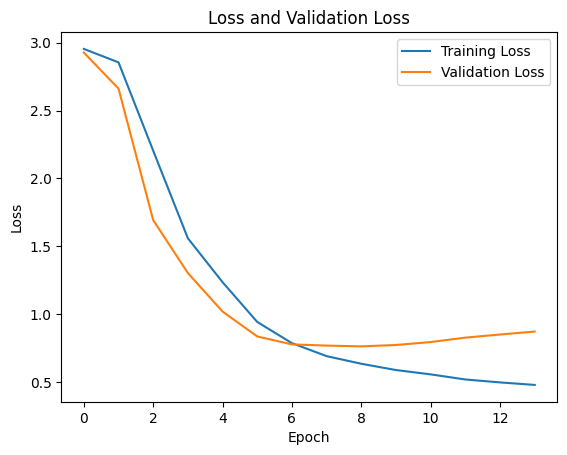

In [15]:
import matplotlib.pyplot as plt

# Plota a perda (loss) e a perda de validação (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Salva arquivos em discos que podemos carregar sem treinar a rede neural novamente
model.save('ge_StackedLSTM.h5')
np.save("X_test_StackedLSTM.npy", X_test)
np.save("y_test_StackedLSTM.npy", y_test)

In [17]:
from tensorflow.keras.models import load_model
import numpy as np

# Carrega arquivos pertinentes ao treinamento da rede neural e X_test e y_test (usados na avaliação de resultados)
model = load_model('ge_StackedLSTM.h5')
X_test = np.load("X_test_StackedLSTM.npy")
y_test = np.load("y_test_StackedLSTM.npy")

# Avaliação de Resultados

In [18]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Acurácia final:', accuracy)

Acurácia final: 0.777180552482605


In [19]:
# Fazer as previsões do modelo para o conjunto de teste
y_pred = model.predict(X_test)

896/896 [==============================] - 10s 11ms/step


In [20]:
#Transformar as previsões de volta em rótulos
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

conf_mat

array([[1206,    6,   15,    4,   10,    5,    8,   28,   80,    7,   25,
          22,   19,   12,   10,   26,   26,    2,   29,    4,    5],
       [  10,  446,    3,    2,    7,    4,    4,    5,    1,    7,    8,
           7,   20,   35,    6,   13,   13,    7,   16,   10,    3],
       [  23,    3, 1152,    3,   11,    4,    5,   19,    9,   39,   21,
           8,   19,    9,    5,   12,   21,    3,   22,    7,    2],
       [  24,    4,    5,  831,    3,    3,   24,   10,    5,   10,   19,
           9,   17,    0,    6,   16,   12,    4,   13,   17,    5],
       [  28,   11,   12,    8, 1184,    9,    8,   22,   17,   12,   75,
          41,   20,   13,   14,   21,   14,    9,   29,    7,   19],
       [  19,    9,    4,    0,    7,  371,    8,   11,    1,    6,    3,
           8,   13,   12,    3,    7,   33,    3,   16,    3,    4],
       [  26,    6,   10,   19,   11,    4,  637,    6,    2,    2,   14,
          10,   66,    5,    7,   14,   21,    1,   17,    9,    0],

In [21]:
import pandas as pd

# Lê o arquivo .csv
df = pd.read_pickle("ge_df.pkl")

# Total de classes (times de futebol)
classes = df['label'].nunique()

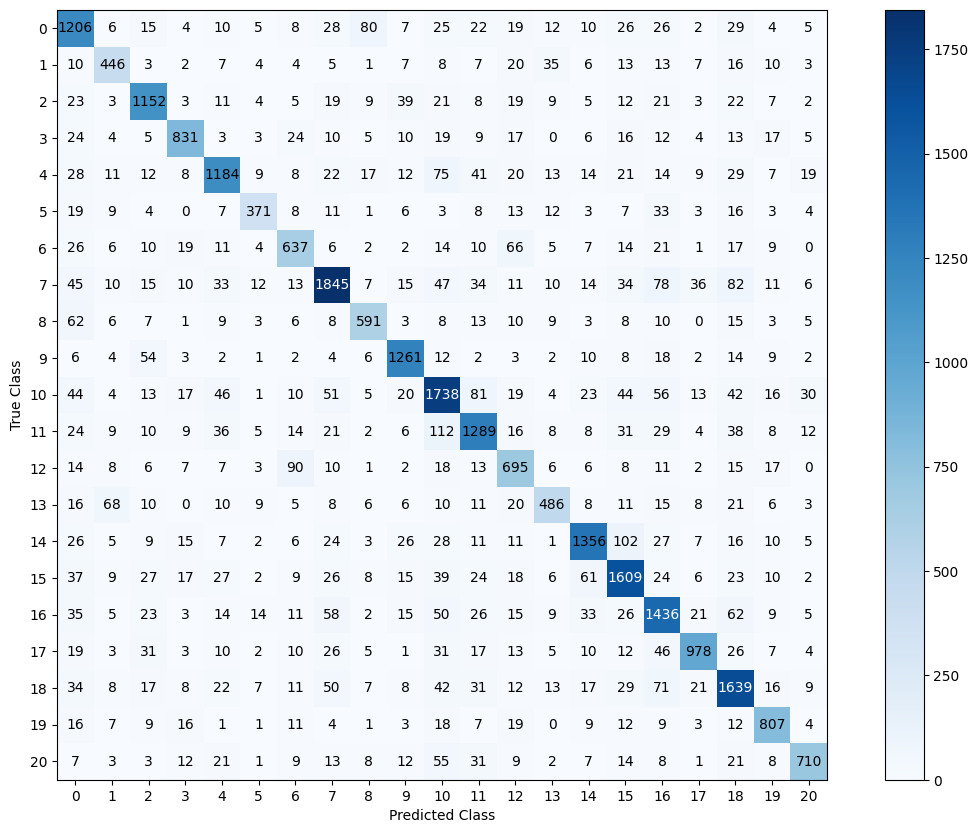

In [22]:
import matplotlib.pyplot as plt

# Define o tamanho da figura
plt.figure(figsize=(15, 10))

# Define mapa de cores
cmap = plt.cm.Blues

# Plota matriz de confusão
plt.imshow(conf_mat, cmap=cmap)
plt.colorbar()

# Adiciona rótulos a matriz
plt.xticks([int(i) for i in range(21)], [str(i) for i in range(21)])
plt.yticks([int(i) for i in range(21)], [str(i) for i in range(21)])

for i in range(classes):
    for j in range(classes):
        plt.text(j, i, str(conf_mat[i, j]), ha='center', va='center', color='white' if conf_mat[i, j] > len(y_true_labels)/ classes else 'black')

# Adiciona rótulos dos eixos
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Mostra o plot
plt.show()

In [23]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcula precisão, recall e f1-score para cada classe
precisions = []
recalls = []
f1_scores = []
for i in range(classes):
    precision = precision_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    recall = recall_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    f1 = f1_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
# Printa resultados
for i in range(classes):
    print(f"Class '{i}': Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1-Score={f1_scores[i]:.4f}")

# Calcula e printa a média dos f1-scores
f1_average = np.mean(f1_scores)
print(f"Average F1-Score: {f1_average:.4f}")

Class '0': Precision=0.7008, Recall=0.7786, F1-Score=0.7376
Class '1': Precision=0.7035, Recall=0.7113, F1-Score=0.7074
Class '2': Precision=0.8028, Recall=0.8246, F1-Score=0.8136
Class '3': Precision=0.8411, Recall=0.8014, F1-Score=0.8207
Class '4': Precision=0.8011, Recall=0.7527, F1-Score=0.7761
Class '5': Precision=0.8013, Recall=0.6858, F1-Score=0.7390
Class '6': Precision=0.7070, Recall=0.7182, F1-Score=0.7125
Class '7': Precision=0.8204, Recall=0.7791, F1-Score=0.7992
Class '8': Precision=0.7705, Recall=0.7577, F1-Score=0.7641
Class '9': Precision=0.8543, Recall=0.8849, F1-Score=0.8694
Class '10': Precision=0.7324, Recall=0.7633, F1-Score=0.7475
Class '11': Precision=0.7605, Recall=0.7623, F1-Score=0.7614
Class '12': Precision=0.6651, Recall=0.7401, F1-Score=0.7006
Class '13': Precision=0.7512, Recall=0.6594, F1-Score=0.7023
Class '14': Precision=0.8391, Recall=0.7991, F1-Score=0.8186
Class '15': Precision=0.7822, Recall=0.8049, F1-Score=0.7934
Class '16': Precision=0.7260, Reca

# Teste com um exemplo real (Flamengo)

In [ ]:
# Criei um dataframe simples com uma notícia só para aplicarmos a função preprocess_data

import pandas as pd
from nltk.tokenize import word_tokenize

value = """Santos diz que grupo do Flamengo na Libertadores é difícil e mira tetracampeonato 

Flamengo desfruta de dias livres para treinar com foco na final do Campeonato Carioca, mas também já mira a estreia na Libertadores. A estreia na competição continental acontece na próxima quarta-feira, entre as finais do Estadual. 

O primeiro jogo será em Quito, no Equador, contra o Aucas, e o goleiro Santos comentou o desejo do Rubro-Negro em conquistar o tetracampeonato na Libertadores. 

- A expectativa é sempre muito boa para que essa competição comece. É a principal competição do nosso continente. O grupo é muito difícil, a gente sabe a dificuldade que é a Libertadores. Cada time teve a sua dificuldade para se classificar. A gente está vivendo uma expectativa boa para a estreia, queremos fazer uma boa competição em busca do objetivo que é ser campeão mais uma vez. 

Mas, antes de focar na estreia da Libertadores, o Flamengo disputa a primeira partida da final com o Fluminense, no sábado. Para o goleiro, o tempo para treinar em meio ao calendário apertado do futebol brasileiro é algo a ser valorizado.

- Semana muito boa com essa pausa para treinarmos. Estamos muito focados nessa decisão. Os treinos estão com muita intensidade e a gente tem aproveitado o máximo possível para chegarmos preparados.

O Flamengo é o atual campeão da Libertadores e luta pelo tetracampeonato. No Carioca, o Rubro-Negro tenta a revanche em cima do Fluminense, que terminou campeão na temporada de 2022. O segundo e decisivo jogo do Estadual acontece no domingo, dia 9.
"""

# Crie um DataFrame com uma linha e a coluna 'data'
df_predict = pd.DataFrame(data={'data': [value]})

# Faz pré-processamento
preprocess_data(df_predict, 'data')

# Conversão dos dados para serem usados no modelo (rede neural)
preprocessed_articles = df_predict['data'].tolist()

sequences_test = []
for tokens in tqdm(preprocessed_articles):
    sequence = []
    for token in tokens:
        if token in word_to_index:
            sequence.append(word_to_index[token])
    sequences_test.append(sequence)
    
padded_example = pad_sequences(sequences_test, maxlen=max_length, padding='post')

# Fazer a previsão usando o modelo
predictions = model.predict(padded_example)

In [ ]:
predictions

In [ ]:
# Identificar a classe com a maior probabilidade
predicted_class = np.argmax(predictions)

# Exibir a classe prevista
print(f"Classe prevista: {predicted_class}")

# Transformando a classe numérica em texto, de volta

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Lê o arquivo .csv
df = pd.read_csv('ge_news.csv')

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Transforma os rótulos de times de futebol para variáveis categóricas
df['label'] = le.fit_transform(df['club'])

original_class = le.inverse_transform([predicted_class]) # Transforma a classe predita de variável categórica para o nome do clube, de volta
print(f"Classe original: {original_class[0]}")

# Teste com um exemplo real (Corinthians)

In [ ]:
# Criei um dataframe simples e com uma notícia só apenas por conta da função preprocess_data

import pandas as pd

value = """Nova camisa do Corinthians: vazam imagens de supostos uniformes para 2023; veja fotos

Imagens de supostas novas camisas do Corinthians para 2023 vazaram nas redes sociais nessa quarta-feira. Foram divulgadas fotos do que seriam os modelos 1 e 2 do uniforme do Timão.

Uma loja de um shopping na Zona Sul de São Paulo já está comercializando as novas camisas branca e listrada. A reportagem do ge entrou em contato com o estabelecimento e teve a confirmação de um funcionário de que as peças já estão à venda por R$ 300 (modelo de torcedor). Confira as imagens abaixo:

As supostas novas camisas do Corinthians para 2023 possui detalhes na cor vermelha ao redor da logomarca da Nike, fornecedora do material esportivo do clube.

Os uniformes alvinegros para este ano homenagearão a Democracia Corinthiana, movimento organizado na década de 1980. CLIQUE AQUI e saiba mais sobre o tema.

Usualmente, o Corinthians lança seus novos uniformes principais entre o fim de abril e o início de maio. Já a terceira camisa costuma ser estreada em setembro, mês de aniversário do clube. 

O Timão volta a campo na próxima quinta-feira, na estreia da Libertadores, contra o Liverpool-URU, às 19h, no estádio Centenário de Montevidéu. 
"""

# Crie um DataFrame com uma linha e a coluna 'data'
df_predict = pd.DataFrame(data={'data': [value]})

# Faz pré-processamento
preprocess_data(df_predict, 'data')

# Conversão dos dados para serem usados no modelo (rede neural)
preprocessed_articles = df_predict['data'].tolist()

sequences_test = []
for tokens in tqdm(preprocessed_articles):
    sequence = []
    for token in tokens:
        if token in word_to_index:
            sequence.append(word_to_index[token])
    sequences_test.append(sequence)
    
padded_example = pad_sequences(sequences_test, maxlen=max_length, padding='post')

# Fazer a previsão usando o modelo
predictions = model.predict(padded_example)

In [ ]:
# Identificar a classe com a maior probabilidade
predicted_class = np.argmax(predictions)

# Exibir a classe prevista
print(f"Classe prevista: {predicted_class}")

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Lê o arquivo .csv
df = pd.read_csv('ge_news.csv')

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Transforma os rótulos de times de futebol para variáveis categóricas
df['label'] = le.fit_transform(df['club'])

original_class = le.inverse_transform([predicted_class]) # Transforma a classe predita de variável categórica para o nome do clube, de volta
print(f"Classe original: {original_class[0]}")

## Referências

* https://www.kaggle.com/datasets/lgmoneda/ge-soccer-clubs-news
* https://medium.com/@everton.tomalok/word2vec-e-sua-import%C3%A2ncia-na-etapa-de-pr%C3%A9-processamento-d0813acfc8ab
* https://www.youtube.com/watch?v=hQwFeIupNP0
* https://www.youtube.com/watch?v=ISPId9Lhc1g
* https://jalammar.github.io/illustrated-word2vec/
* https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92